In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import AFLCIO Dataset

df = pd.read_csv('ALFCIO Speeches.csv')

In [3]:
df

,Unnamed: 0,Speech Title,Url Link,Date,Speech Text,Speaker
0,0,Shuler: We Can Make Dr. King's Dream a Reality,https://aflcio.org/speeches/shuler-we-can-make...,1-13-2023,AFL-CIO President Liz Shuler delivered the fol...,Shuler
1,1,Redmond: We Must Be That Mighty Force for Change,https://aflcio.org/speeches/redmond-we-must-be...,1-13-2023,AFL-CIO Secretary-Treasurer Fred Redmond deliv...,Redmond
2,2,Redmond: Technological Achievement Should Not ...,https://aflcio.org/speeches/redmond-technologi...,1-6-2023,AFL-CIO Secretary-Treasurer Fred Redmond's rem...,Redmond
3,3,Shuler: Innovation Should Empower Workers and ...,https://aflcio.org/speeches/shuler-innovation-...,1-6-2023,AFL-CIO President Liz Shuler's remarks as prep...,Shuler
4,4,Redmond: We Need the Missouri Labor Movement N...,https://aflcio.org/speeches/redmond-we-need-mi...,8-22-2022,Secretary-Treasurer Fred Redmond delivered the...,Redmond
...,...,...,...,...,...,...
404,404,Shuler 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/shuler-2013-afl-ci...,9-10-2013,Wow! Thank you. Thank you all so much.Brother...,Shuler
405,405,Gebre 2013 AFL-CIO Convention Acceptance,https://aflcio.org/speeches/gebre-2013-afl-cio...,9-10-2013,"Thank you, brothers and sisters, for your conf...",Gebre
406,406,Trumka 2013 AFL-CIO Convention Keynote,https://aflcio.org/speeches/trumka-2013-afl-ci...,9-9-2013,Thank you. Thank you for being here. Together...,Trumka
407,407,Remarks of AFL-CIO President Richard L. Trumka...,https://aflcio.org/speeches/remarks-afl-cio-pr...,9-6-2013,Thank you for all for coming together here in ...,Trumka


In [4]:
#often, we want to remove stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
                     'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 
                     'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
                     'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
                     'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
                     'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
                     'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
                     'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                     'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 
                     'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
                     'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will',
                     'just', 'dont', 'should', 'aint', 'arent', 'couldn', 'could', 'would', 'much', 'must',
                     'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shan',
                     'shouldnt', 'wasnt', 'werent', 'wont', 'wouldnt','rt','mt','amp','mil','ve','don','s','st','pres','req','aft','ua']

In [5]:
 #adopted from catriscode, https://catriscode.com/2021/05/01/tweets-cleaning-with-python/

import numpy as np
import re

def clean_speech(speech):
    """cleans the speech"""
    raw_speech = str(speech)
    if type(speech) == float:
        return ""
    temp = re.sub("'", "", str(speech)) # to avoid removing contractions in english
    temp = temp.lower()
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub(r"www.\S+", "", temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    #temp = re.sub("[^a-z0-9]"," ", temp) # this removes all letters including CO2
    temp = re.sub("[^a-z]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    
    if temp is None:
        print (raw_speech,temp)
        
    return temp

# create a clean text column
df['clean_text'] = df['Speech Text'].apply(clean_speech)

In [6]:
# remove the speakers and the orginization afl due to it being mentioned 
# in the beginning of every speech

# define a lowercased speaker list and include afl
speakers = list(df['Speaker'].unique())
speakers = [i.lower() for i in speakers]
# add specific words 

words_to_remove = ['cio', 'president', 'thank', 'secretary', 'treasurer', 'afl', ' cio',
                  'us', ' re', ' t', ' ll', ]

for word in words_to_remove:
    speakers.append(word)
    print(word)

print(speakers)

def remove_afl(speech):

    for word in speakers:
        
        temp = re.sub(word, '', speech)
    return temp

cio
president
thank
secretary
treasurer
afl
 cio
us
 re
 t
 ll
['shuler', 'redmond', 'afl', 'gebre', 'trumka', 'cio', 'president', 'thank', 'secretary', 'treasurer', 'afl', ' cio', 'us', ' re', ' t', ' ll']


In [7]:
df['processed_clean'] = df['clean_text'].apply(remove_afl)

In [8]:
df['processed_clean_list'] = [l.split() for l in df['processed_clean']]

In [9]:
df['processed_clean_list'][10]

['president',
 'liz',
 'shuler',
 'delivered',
 'following',
 'remarks',
 'prepared',
 'ibews',
 'th',
 'convention',
 'chicago',
 'good',
 'morning',
 'everyone',
 'thank',
 'president',
 'stephenson',
 'kind',
 'introduction',
 'secretary',
 'treasurer',
 'cooper',
 'incredible',
 'job',
 'leading',
 'ibew',
 'm',
 'grateful',
 'everything',
 'afl',
 'cio',
 'congratulations',
 're',
 'election',
 'm',
 'proud',
 'ibew',
 'member',
 'watch',
 'union',
 'reach',
 'new',
 'heights',
 'leadership',
 'congratulations',
 'international',
 'vice',
 'presidents',
 'international',
 'executive',
 'councii',
 'members',
 'elections',
 'give',
 'special',
 'shout',
 'th',
 'district',
 'vp',
 'paul',
 'noble',
 'started',
 'weeks',
 'ago',
 'already',
 'national',
 'convention',
 'backyard',
 'well',
 'done',
 'paul',
 'absolute',
 'honor',
 'ibew',
 'convention',
 'm',
 'home',
 'heard',
 'grew',
 'electric',
 'utility',
 'industry',
 'generations',
 'worked',
 'company',
 'back',
 'like',
 '

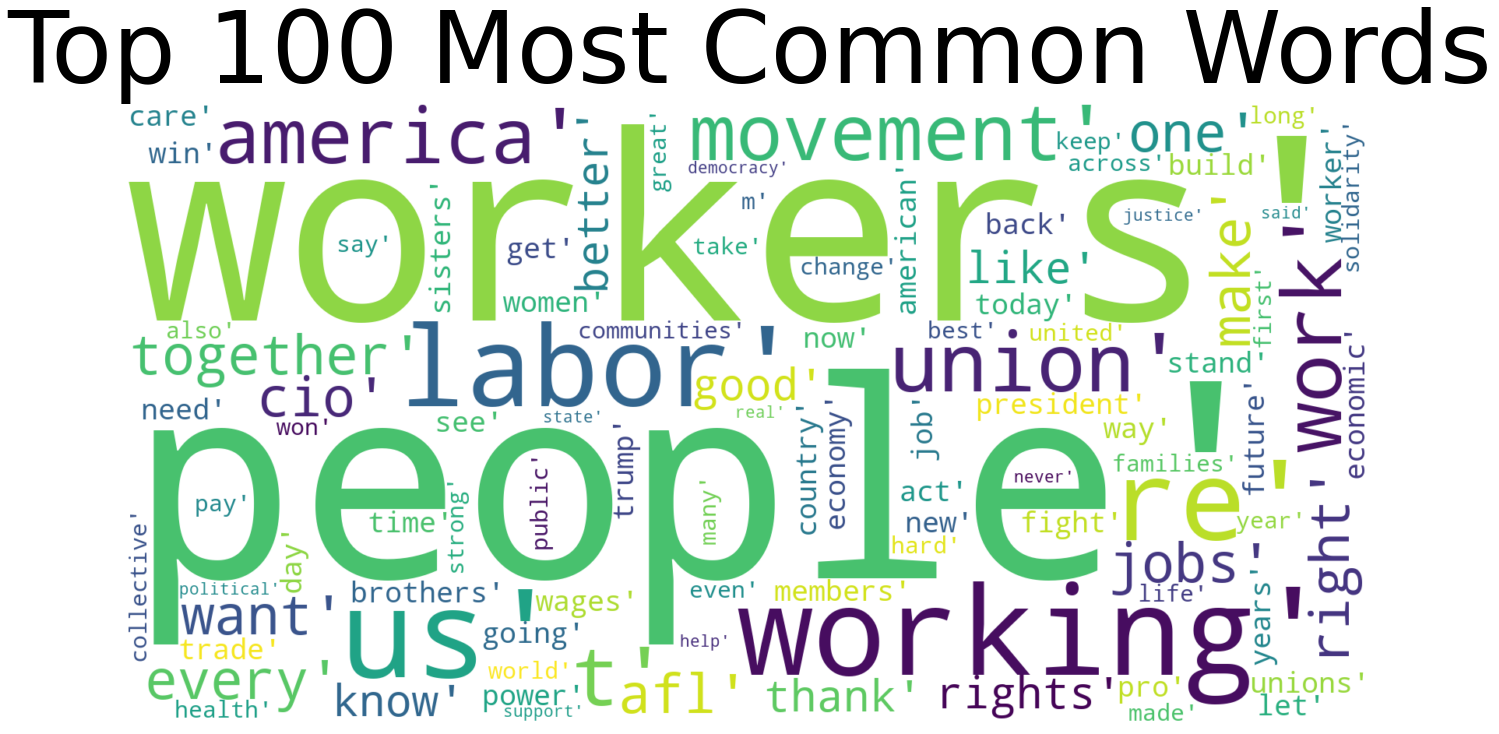

In [10]:
# creating a wordcloud of the most common words
words = df['processed_clean_list']
allwords = []
for wordlist in words:
    allwords += wordlist


mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

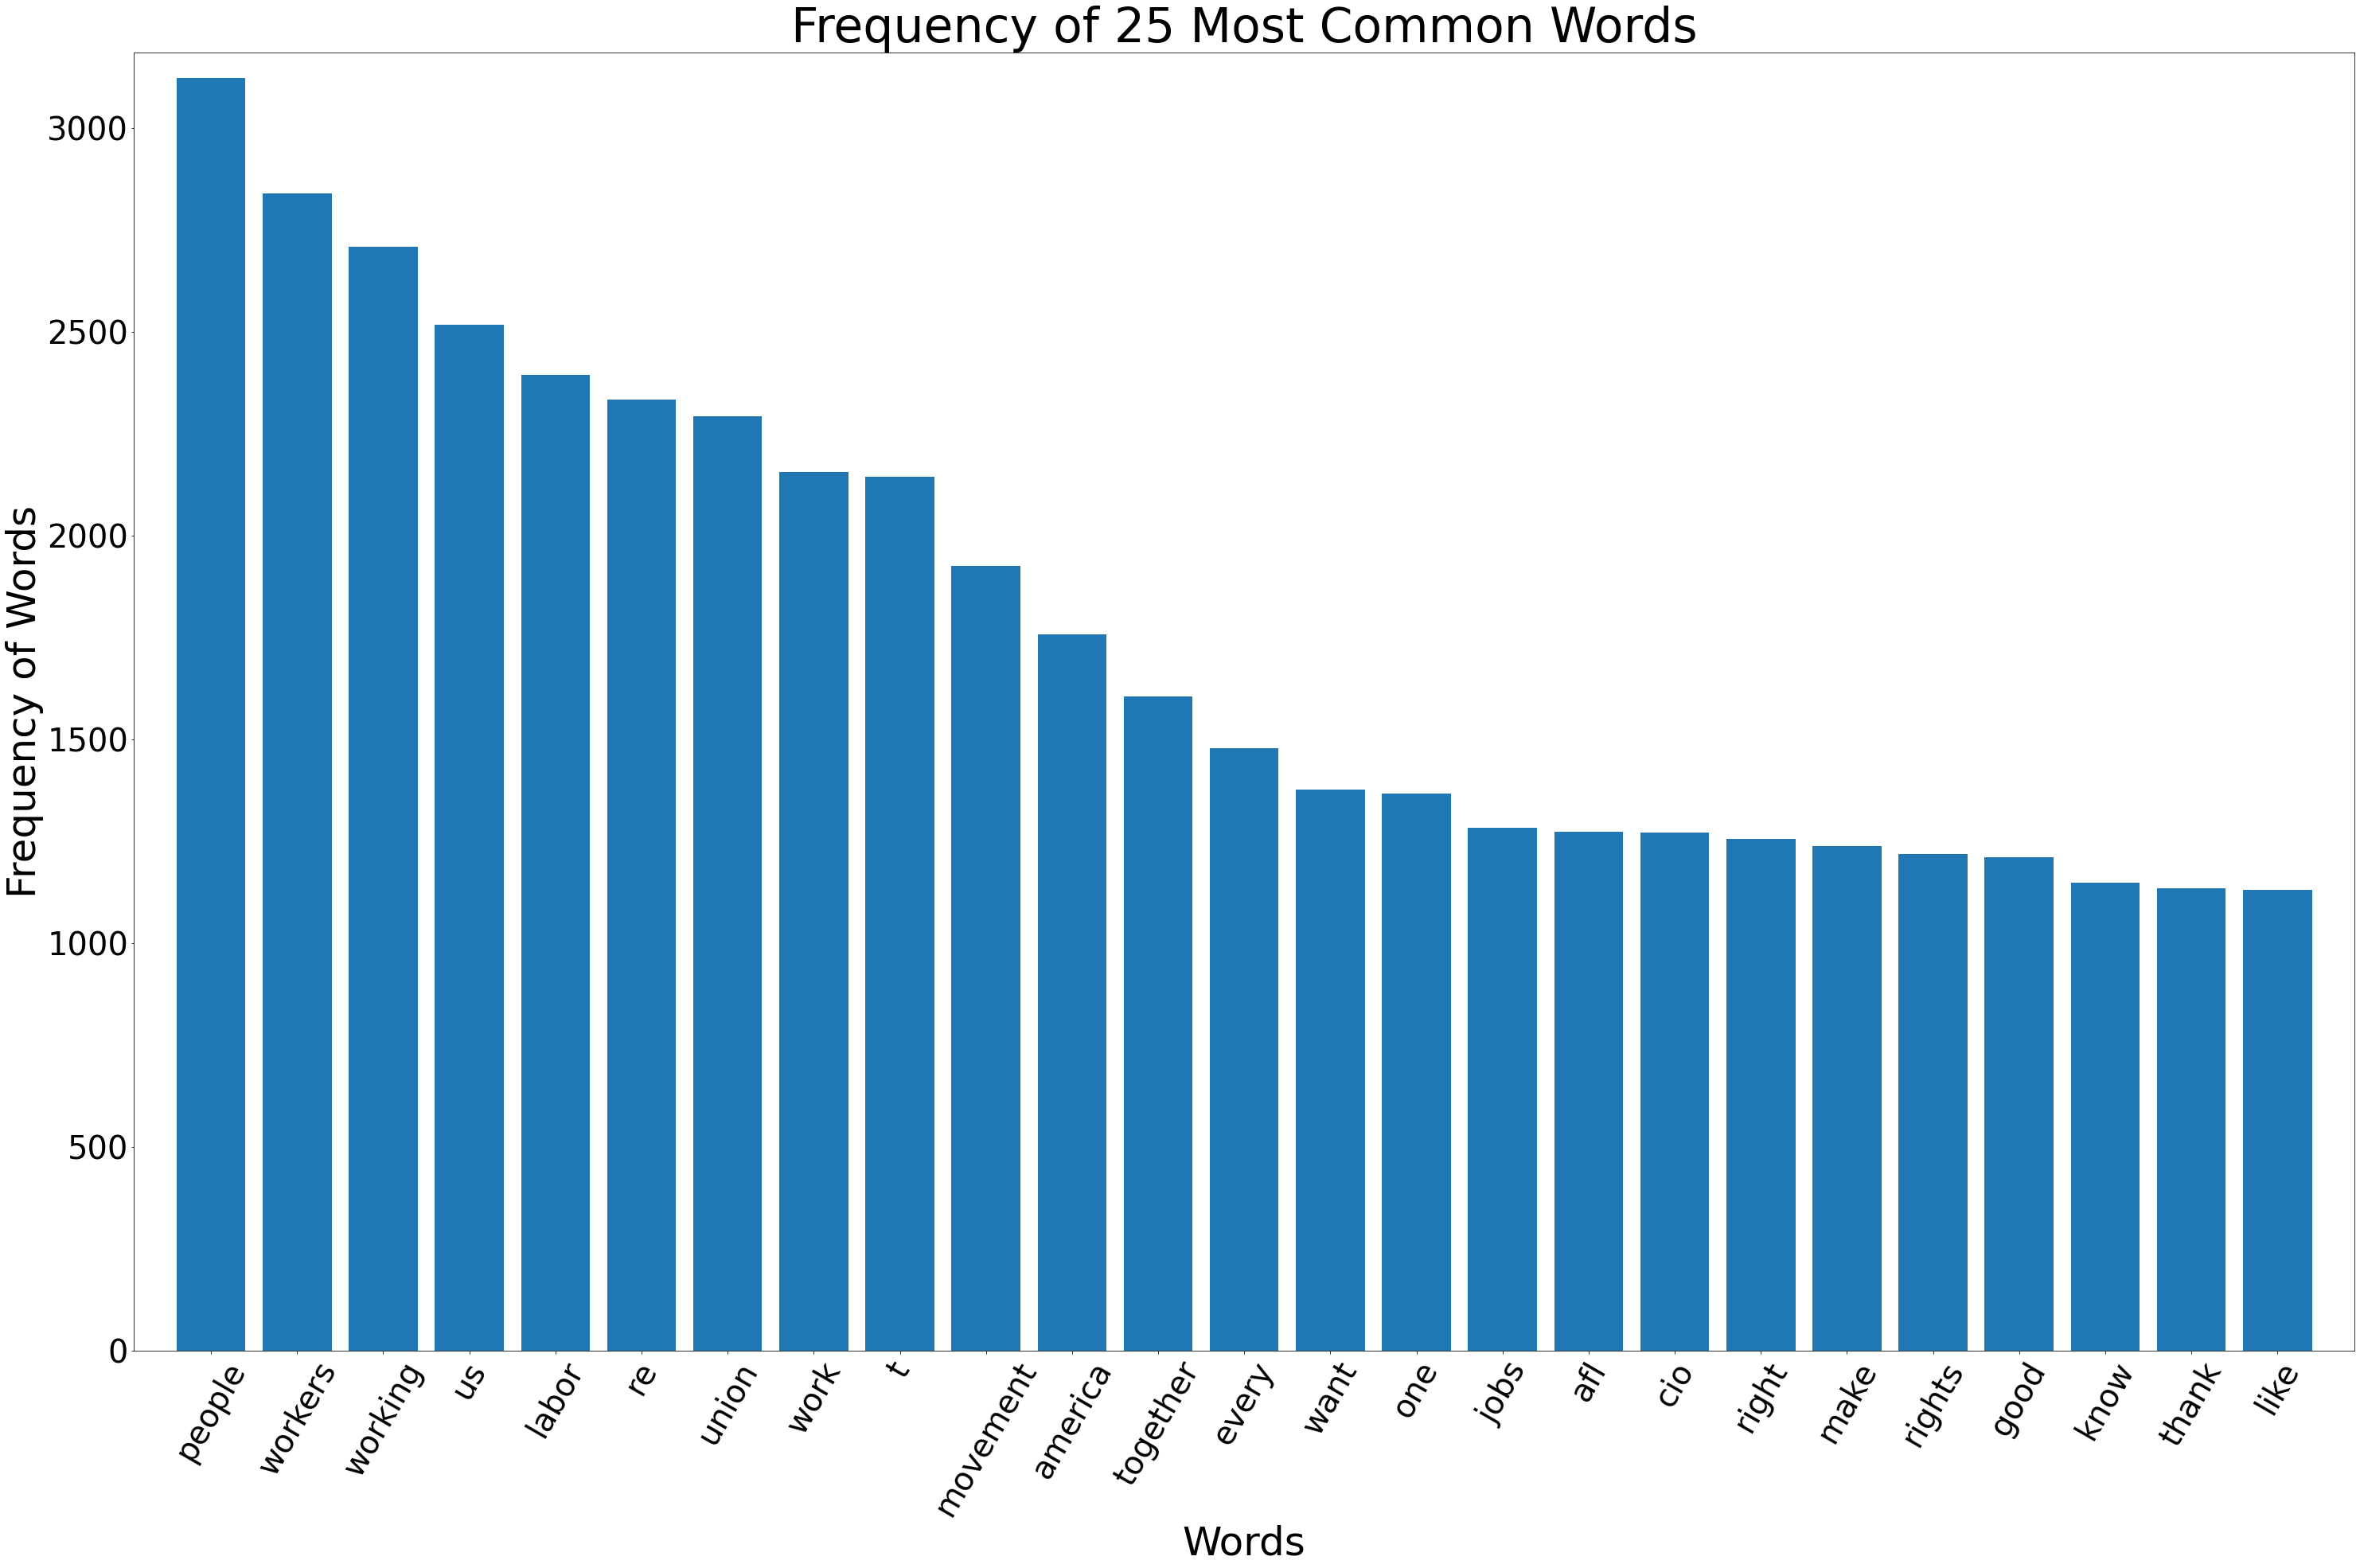

In [11]:
# plotting the frequency of the 25 most common words

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()